# Data Augmentation
- 데이터 양을 늘리기 위해 원본 이미지에 각종 변환을 적용해 데이터 수를 늘리는 기법
- 변환들에 대해서도 모델이 적용할 수 있게
- 직접 구현하는 경우는 거의 없고 3-part library사용
- 유명한 라이브러리를 고르는게 도움이 됨

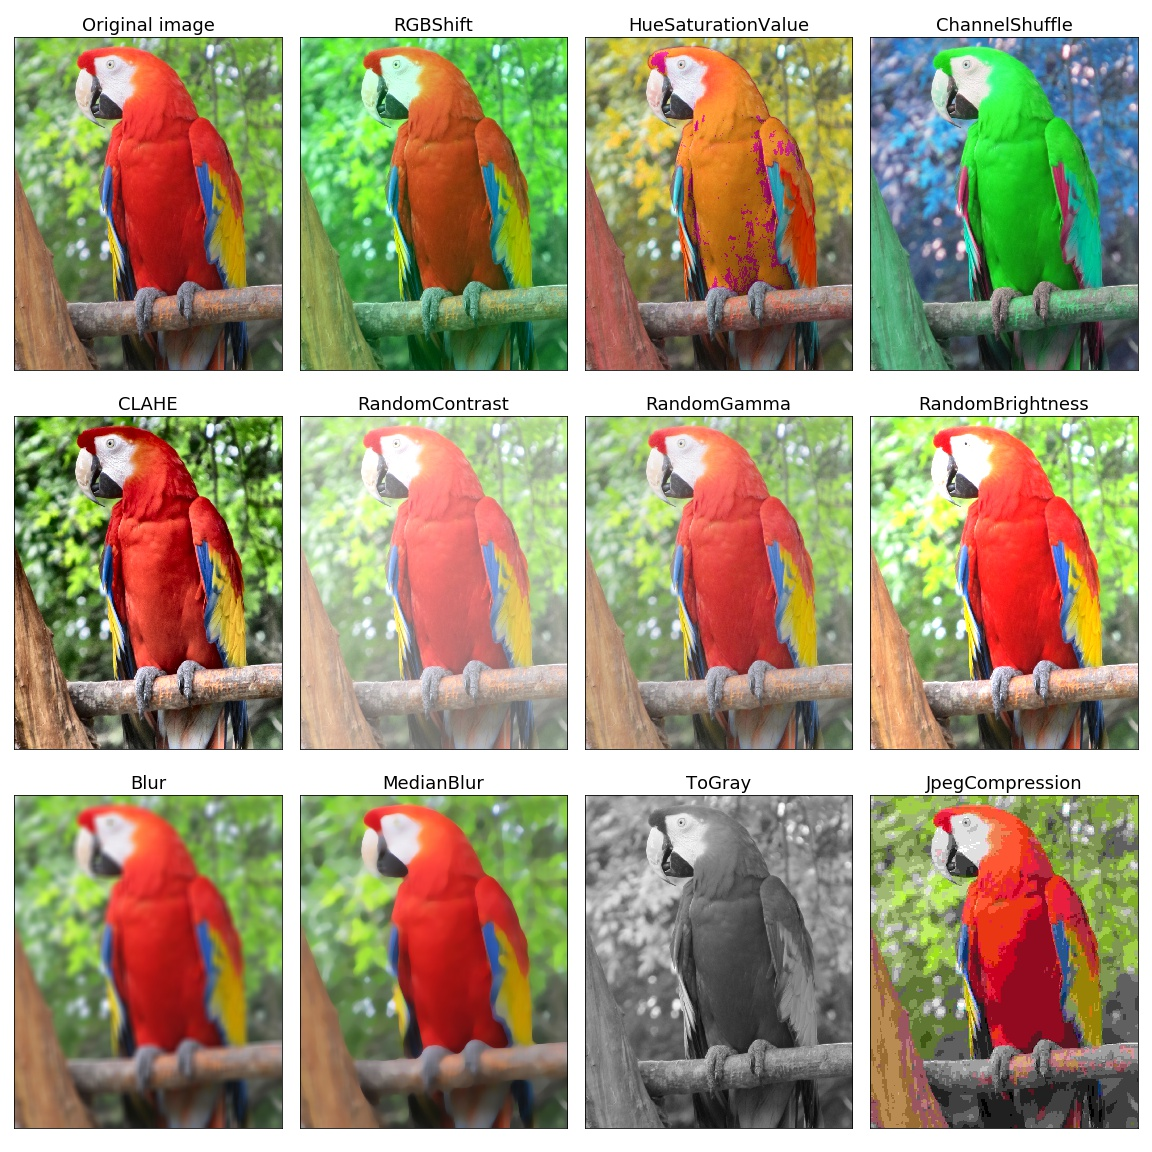

# Albumentations

https://github.com/albumentations-team/albumentations

- 캐글러가 만든 라이브러리

In [1]:
#!python -m pip install --user albumentations

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\82103\\anaconda3\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import albumentations as A
import cv2

class Augmentation: #학습단계에서 많이 사용됨
    def __init__(self, size, mode='train'):
        if mode == 'train':#학습단계에서만 변환들이 적용될 수 있게
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5), # 좌우 반전, p : 해당 변화를 적용할 확률
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05, #이미지를 가로길이의 몇 퍼센트만큼 움직일건지(보통 작은 숫자로 지정)
                    scale_limit=0.05, #이미지를 최대 5%까지 확대, 축소
                    rotate_limit=15, #회전 15도
                ), #매번 다른 확률로 변환이 적용된다
                A.CoarseDropout(#이미지에 사각형 구멍을 뚫는 기법(?)
                    p=0.5,
                    max_holes=8,#최대 구멍 개수
                    max_height=int(0.1 * size), #구멍 세로 길이는 최대 10%까지
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):#객체가 호출이 됐을때 이미지에 변환이 적용되도록 설정
        if self.transform: #모드게 trian으로 세팅이 되어있을때만 적용
            augmented = self.transform(**kwargs)#이미지를 넘겨줌
            img = augmented['image']
            return img#이미지 리턴

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.fold = fold
        self.shuffle = shuffle
        self.mode = mode
        self.batch_size = batch_size
        self.image_size = image_size
        
        self.df = pd.read_csv(csv_path)
        if self.mode == 'train':    
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
    
        for _, r in data.iterrows():
            file_name = r['file_name']

            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train': #이미지 불러온 다음 augmentation 바로 적용
                image = image.astype('uint8')
                image = self.transform(image=image)
            #이미지 augmentation을 적용할때 unit8에서만 적용되는 경우가 있음 
            image = image.astype('float32')
            image = image / 255.

            label = int(r['species']) - 1

            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

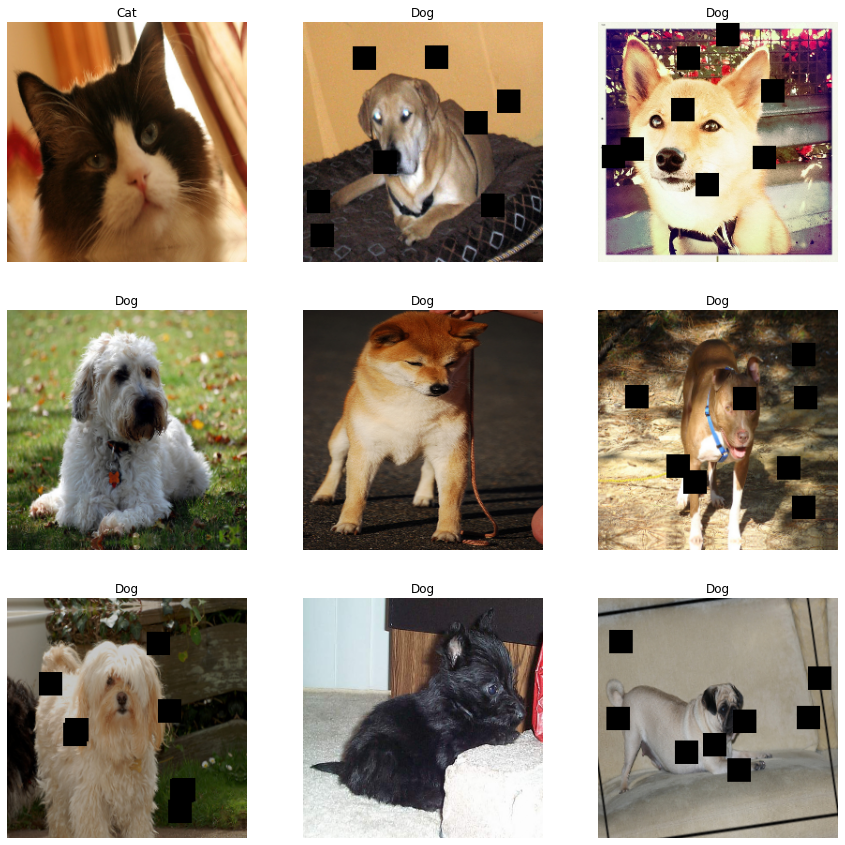

In [7]:
class_names = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    break

In [8]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),

            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        
            # Classfier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )

    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     1

In [9]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)
#분류모델의 성능은 약 0.69의 정확도
#augmentation을 적용하지 않았을때와 비슷
#다음 강의에서는 augmentation을 적용해도 차이가 얼마 안나는 이유 알아볼 것

Epoch 1/10
 1/46 [..............................] - ETA: 31:05 - loss: 1.7838 - accuracy: 0.3438

KeyboardInterrupt: 

In [8]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt

In [13]:
image = cv2.imread('data/example.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

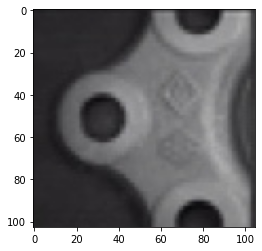

In [15]:
plt.imshow(image)

In [35]:
transform = A.Compose([
    A.HorizontalFlip(p=0), # 좌우 반전, p : 해당 변화를 적용할 확률
    A.ShiftScaleRotate(
        p=1,
        shift_limit=0.10, #이미지를 가로길이의 몇 퍼센트만큼 움직일건지(보통 작은 숫자로 지정)
        scale_limit=0.05, #이미지를 최대 5%까지 확대, 축소
        rotate_limit=15, #회전 15도
    ), #매번 다른 확률로 변환이 적용된다
    A.RandomBrightnessContrast(p=0),
    
])

In [36]:
transformed = transform(image=image)
transformed_image = transformed['image']

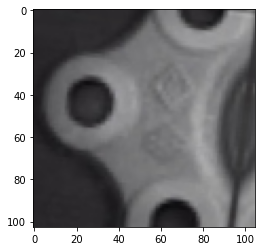

In [37]:
plt.imshow(transformed_image)